# Previous ...

In [ ]:
# import torch
# import torch.nn as nn
# from dataclasses import dataclass
# from torch.nn import functional as F

> **Not theory focused, only code focused to wrap up my model ... We begin ...**

## **00:00:00 - 00:13:48**
December 24th 2025 - 0200<br>
December 24th 2025 - 0540

- Loaded the weights from OpenAI
- Looked at the geometry of the weights
- Used the HuggingFace Transformers 
- We got the raw weight, the pipeline and sample from it

    Validation Loss [val/loss] plot
    > measures "how good our model is in predicting the next token in a sequence on some validation data that model has not seen during training."

    we can may reproduce the GPT2 model in less than an hour, and it would cost you about 10 bucks on cloud computer if you want to rent, and at this situation you wait about an hour or less and then achieve a model which is as good as the original GPT2 model 124M by OpenAI.

    we will be referencing the GPT3 paper [Language Models are Few-Shot Learners] for reproducing the model. The departure is not so far than that of GPT2 model

## **00:03:40 - 00:00:00**

    Step 1 - Loading the GPT2 124M model released by OpenAI and sample tokens from it

    Step 2 - we are going to use HuggingFace transformers. The transformers / src / transformers / models / modeling_gpt2.py path in HuggingFace's github converted all the code from GPT2's TensorFlow to PyTorch, which is much easier to load and work with

In [ ]:
# from transformers import GPT2LMHeadModel

/Users/soheilsanati/.Trash/GPT2_124Me/.GPT2/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
# sd_hf = model_hf.state_dict()

> # taking the positional embeddings

In [ ]:
# sd_hf["transformer.wpe.weight"].view(-1)[:20];

> # plotting the row x columns geometry of "transformer.wpe.weight" in plt

- every row in the visualization below is a different position, a fixed absolute position in the range form 0 to 1023, and each row is the representation of that position.

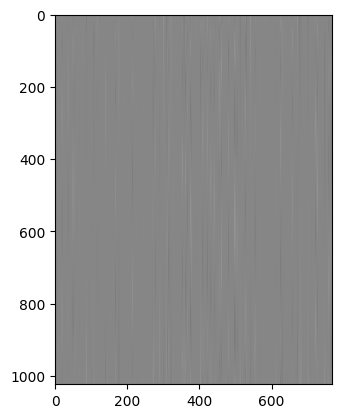

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.imshow(sd_hf["transformer.wpe.weight"], cmap='gray')

- following graphs are channels
- the reason they are jagged it's because the model was not fully trained 
- the more trained the model was, the more we could expect a smoother channel
- so this tells that we are looking at an under-trained model
- in the original transformer "Attention Is All You Need" paper the positional embeddings are actually initialized and fixed to sinusoids and cosines of different frequencies. So that is the positional encoding and it's fixed.

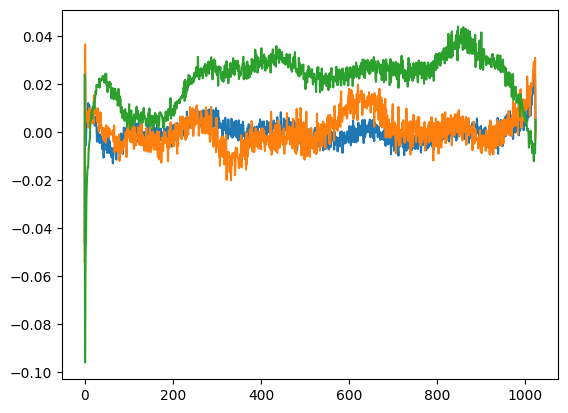

In [ ]:

# plt. plot(sd_hf["transformer.wpe.weight"][:, 150]) # focusing on every single channel and we are looking at what the channel is doing as a function of position from 0 to 1023
# plt. plot(sd_hf["transformer.wpe.weight"][:, 200])
# plt. plot(sd_hf["transformer.wpe.weight"][:, 250])

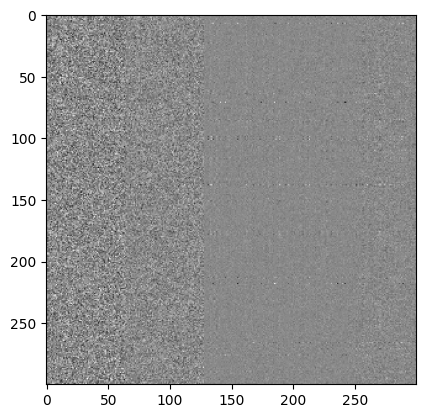

In [ ]:
# # the first layer of the transformer, and looking at one of its weights
# # needed for Mechanistic Interpretability
# plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

So far

- We loaded the weights, that was released by OpenAI
- and then using the HuggingFace Transformers 
- not only we can get the raw weight, 
- but also the pipeline and sample from it

In [ ]:
# from transformers import pipeline, set_seed

# generator = pipeline("text-generation", model = "gpt2")
# set_seed(42)

# # "Hello, my name is Soheil" is the prefix ...
# # max_length=30 sampling 30 tokens
# # num_return_sequences=1 number of sequences 
# generator("Hello, my name is Soheil", max_length=30, num_return_sequences=5);

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


KeyboardInterrupt: 

What we have achieved so far?

- we loaded the model
- we can look at the model's parameters and the keys

Next

- we will write our own GPT class, so to have a full understanding of what is happening 
- our first task
    - loading the gpt2 on 124M to the class that we are going to develop from scratch
    - this is going to give us confidence that we load the OpenAI model 
    - and therefore there is a settings of weights that exactly is 124M models
    - but we will initialized the model from scratch instead and train it ourselves on bunch of documents 
    - and we are going to surpass that model
    - so everything is going to look different, weights, etc ...
    - since we can load the OpenAI model, then we have the confidence that we are in the same model family in model class
    - and we need to rediscover the setting of the weights from scratch

    - ... So we will write the GPT2 model 
    - ... load the weights
    - ... and make sure that we can also generate text

## **00:13:48 - 00:28:10**

- Building the GPT124M Model

## **1 - Skeleton that reflects the modified GPT2 original Transformer**

- The GPT is slightly a modified version of the original transformer, so area drawn in red, the Encoder and the connected cross attention block using the Encoder, is all missing; therefore, the GPT is a DECODER only transformer.

- Everything else in this transformer stays the same, however, there are two tuning and modification are there!
    1. In the GPT2 paper, under the '2.3. Model' section, we notice that there is a reshuffling of the LayerNorms [The Layer Normalization], so they change place.

    2. An additional LayerNorm was added to the final "Self-Attention" block. That is all the LayerNorms instead of being after the MLP or after the Attention, they swing before it. And, then an additional LayerNorm gets added before the very last Linear block, in the image, right before the "final classifier"

    Now let's implement the first skeleton of the "nn.Modules", and we will try to match to the schema that of used HuggingFace transformers, as it makes it much easier to load all the weights, from the "state.dict()"

    I meant the following:
    
    - transformer.wte.weight torch.Size([50257, 768])
    - transformer.wpe.weight torch.Size([1024, 768])
    - and then blah blah blah ...

### The configuration

In [ ]:
# @dataclass
# class GPTConfig:
#     block_size: int = 256
#     vocab_size: int = 65
#     n_layer: int = 6
#     n_head: int = 6
#     n_embd: int = 384

### The GPT2 Skeleton [transformer block]

- "self.transformer" is the container which has all the modules: the wte, wpe, and so on. Same we saw for the original HF transformer ...
- "nn.Module" allows you to index into the sub_modules using keys, just like a dictionary "strict.dict()"
- "nn.Embedding" is just fancy wrapper module around just a single array of numbers, the block of number just like we saw in gray plane, a single tensor.
    - "nn.Embedding" is a glorified wrapper around the tensor that allows you to access its elements by indexing into the rows.
- As we remember from the:

transformer.wte.weight torch.Size([50257, 768])<br>
transformer.wpe.weight torch.Size([1024, 768])<br>
transformer.h.0.ln_1.weight torch.Size([768])<br>
transformer.h.0.ln_1.bias torch.Size([768])<br>
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])<br>
transformer.h.0.attn.c_attn.bias torch.Size([2304])<br>
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])<br>
transformer.h.0.attn.c_proj.bias torch.Size([768])<br>
transformer.h.0.ln_2.weight torch.Size([768])<br>
transformer.h.0.ln_2.bias torch.Size([768])<br>
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])<br>
transformer.h.0.mlp.c_fc.bias torch.Size([3072])<br>
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])<br>
transformer.h.0.mlp.c_proj.bias torch.Size([768])<br>
...<br>
transformer.h.11.ln_1.weight torch.Size([768])<br>
transformer.h.11.ln_1.bias torch.Size([768])<br>
transformer.h.11.attn.c_attn.weight torch.Size([768, 2304])<br>
transformer.h.11.attn.c_attn.bias torch.Size([2304])<br>
transformer.h.11.attn.c_proj.weight torch.Size([768, 768])<br>
transformer.h.11.attn.c_proj.bias torch.Size([768])<br>
transformer.h.11.ln_2.weight torch.Size([768])<br>
transformer.h.11.ln_2.bias torch.Size([768])<br>
transformer.h.11.mlp.c_fc.weight torch.Size([768, 3072])<br>
transformer.h.11.mlp.c_fc.bias torch.Size([3072])<br>
transformer.h.11.mlp.c_proj.weight torch.Size([3072, 768])<br>
transformer.h.11.mlp.c_proj.bias torch.Size([768])<br>
transformer.ln_f.weight torch.Size([768])<br>
transformer.ln_f.bias torch.Size([768])<br>
lm_head.weight torch.Size([50257, 768])<br>

- the "h" stands for "hidden" probably, and then by using the "nn.ModuleList" we can index into the "h" same as .0, .1, and etc ...
- According to the GPT2 paper we need to have a "final layer norm", as discussed before, so "ln_f" is the final LayerNorm
- "self.lm_head" is our final classifier, "lm_head" stands for Language Model Head, which project from 768, the number of embedding dimensions, all the way to the "vocab_size" which is 50,257, and by "bias=False" GPT uses no bias with the final projection

In [ ]:
# # skeleton of the GPT2
# class GPT(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.vocab_size is not None
#         assert config.block_size is not None
#         self.config = config

#         self.transformer = nn.ModuleDict(dict(
#             wte = nn.Embedding(config.vocab_size, config.n_embd),
#             wpe = nn.Embedding(config.block_size, config.n_embd),
#             # drop = nn.Dropout(config.dropout),
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = nn.LayerNorm(config.n_embd), # , bias=config.bias
#         ))
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

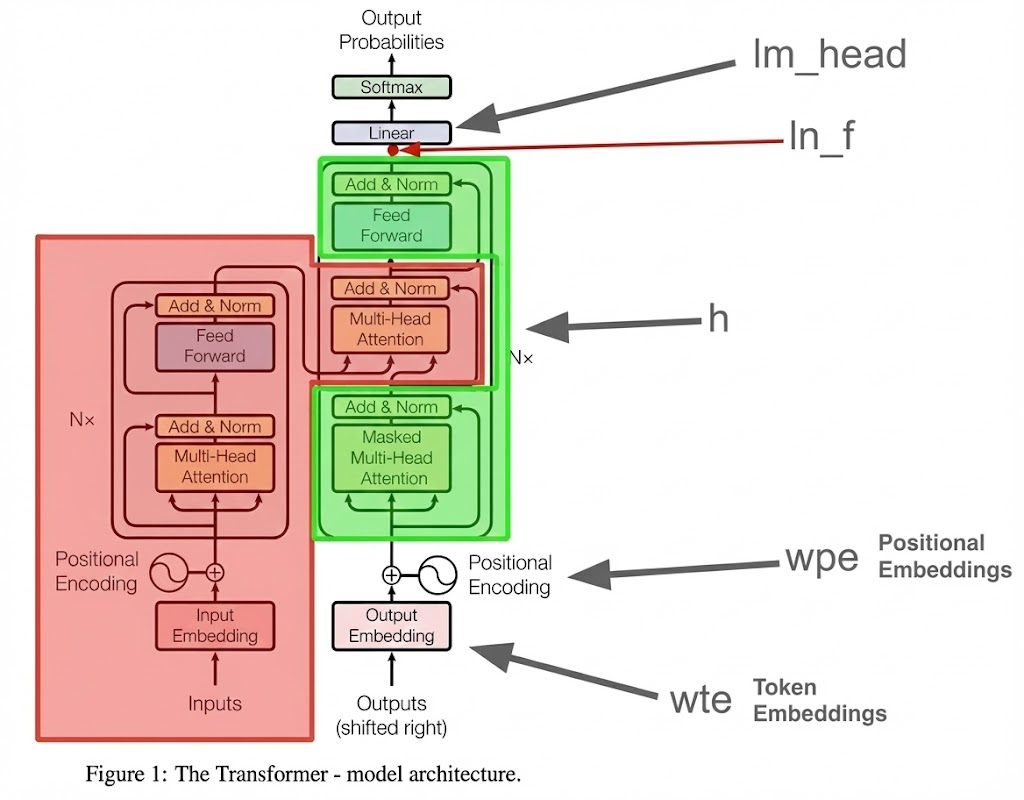
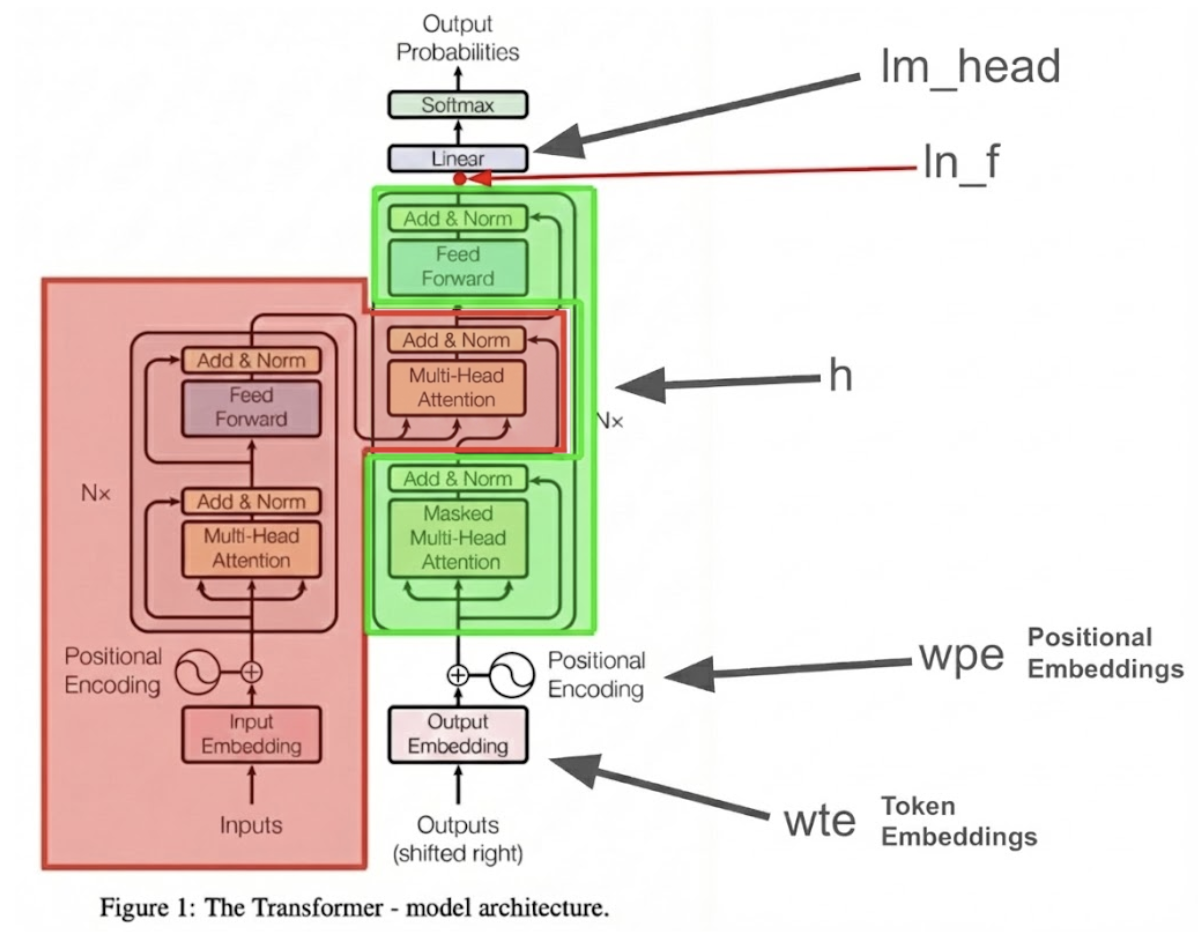
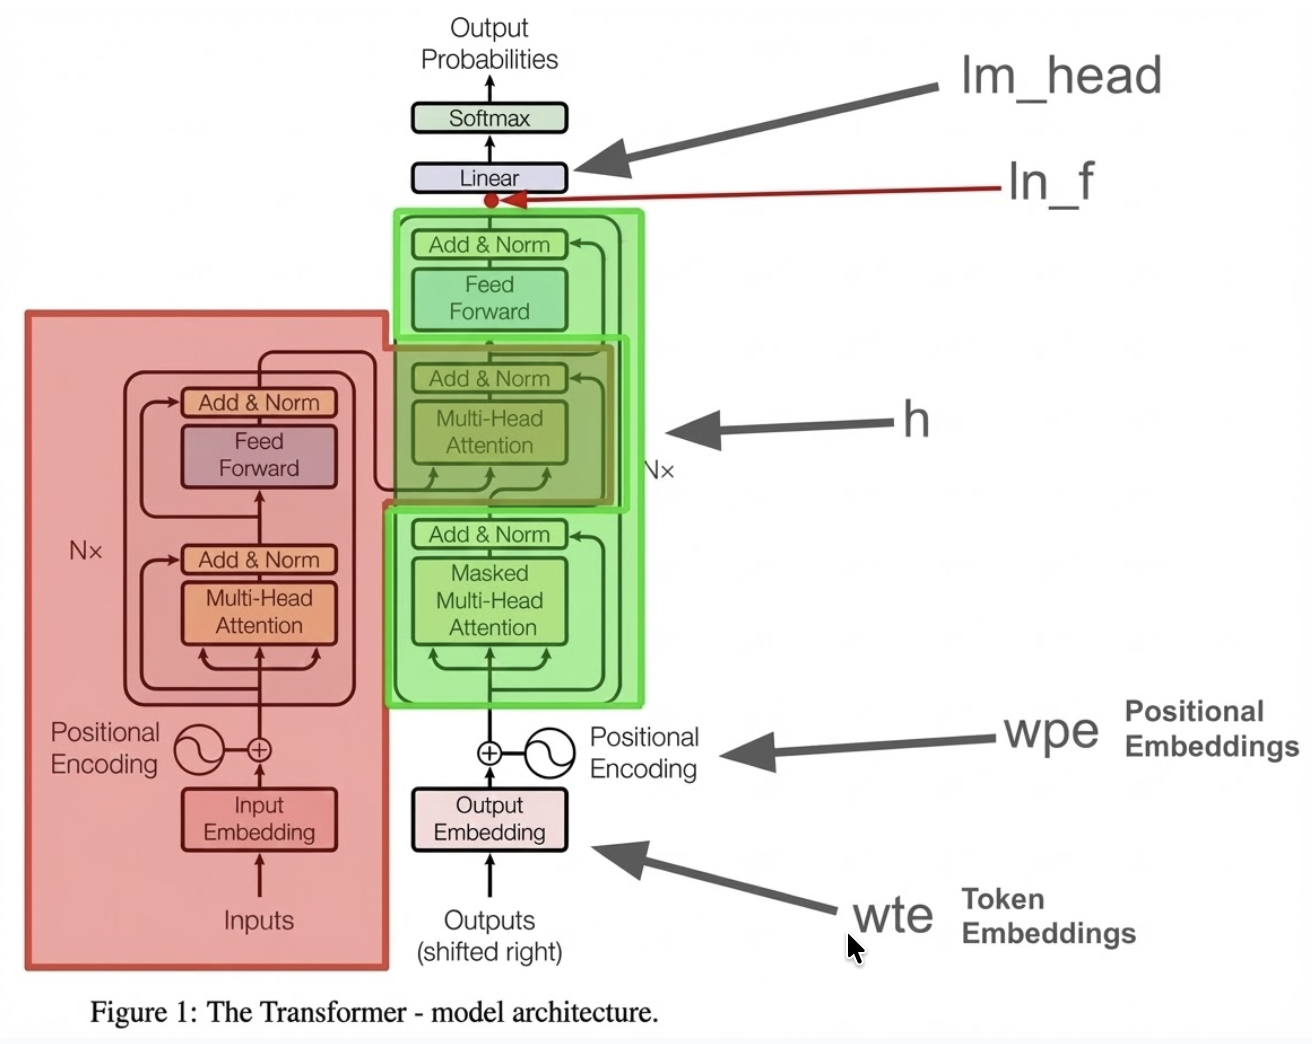

### The " Transformer Block" in "h", within the GPT2 Skeleton

    Things we need to pay a close attention to regarding the "Block" below, using the Skeleton we provided above

    -> 1st/ 
            the "Layer Normalisations" are after the "Attention" and "Feed Forward"
    
    -> 2nd/ 
            the "Layer Normalisations" are inside the "Residual Connection" stream, as we can see in the picture, the arrow for the "Residual" goes through the "Layer Normalisations". So, this all means that the "Residual" path way has "Normalisations" inside them, which is NOT GOOD AND DESIRABLE! As, we would like to have SINGLE AND CLEAN 'RESIDUAL' STREAM, all the way from "Supervision" down to the "Inputs/the Tokens", which is very NICE AND DESIRABLE, Why? Because the GRADIENTS that flow from the top, from MicroGrad [the addition just distributes gradients during the backward stage to both of its branches, equally. So, addition is a branch in the gradients, so that means that the gradient from the top flows straight to the input tokens, through the residual pathways unchanged, but in addition to that the gradients also flows through the blocks, and the blocks contribute there own, contribution over timing, kick in and change the optimization over time] So, basically the clean residual pathway is desirable from an optimization perspective. And the the two lines inside the forward pass, are the Pre-Normalisations, where "x" goes first through the first normalisation 'x = x + self.attn(self.ln_1(x))', and then the "attention", and then goes backout to the 'ln_2(x)' and then the Feed Forward [MLP], and to the residual stream.

In [ ]:
# class MLP(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#         self.gelu    = nn.GELU(approximate="tanh")
#         self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#         self.dropout = nn.Dropout(config.dropout)

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         x = self.dropout(x)
#         return x

In [ ]:
# class Block(nn.Module):

# # initializations
#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
#         self.attn = CausalSelfAttention(config)
#         self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
#         self.mlp = MLP(config)

# # Forward pass
#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x))
#         x = x + self.mlp(self.ln_2(x))
#         # x_out = x + self.attn(self.ln_1(x)) + self.mlp( x + self.attn(self.ln_1(x))) >>> Pre-LayerNorm Transformer block [I added does not exit in the original code by Karpathy]
#         return x

    [Source: I asked ChatGPT 5.2: "What is the path 'x' takes? "]
    
    Shape of the x: (B, T, C)

    Step 1 — First residual block (Attention)
        'y = self.ln_1(x)' >>> LayerNorm is applied per token, across feature dimension C
        'a = self.attn(y)' >>> Self-attention mixes information across time T
        'x = x + a' >>> Residual (skip) connection

    Step 2 — Second residual block (MLP)
        'z = self.ln_2(x)' >>> Normalize the updated representation
        'm = self.mlp(z)' >>> MLP is token-wise (no mixing across time)
        'x = x + m' >>> Second residual connection
    
    Pre-LayerNorm Transformer block.
    Let:
        A(x) = attn(ln₁(x))
        M(x) = mlp(ln₂(x))
    Then:
        x_out = x + A(x) + M(x + A(x))

    [From Karpathy]

        Residuals → stable gradients
		Pre-LN → training doesn’t blow up at depth

		Attention → token interaction :
        
            communication operation, where, in our model, 1024 lined up communicating by one another and exchange information. 
            So, an aggregation function, so a reduce operation,
            Somewhere, tokens communicate by one another.

		MLP → per-token nonlinearity : 
        
            This is the Map! MLP happens at every single token. 
            So, his is where tokens think individually, about the information that they have gathered.

    So! A Transformer is a repeated application of map-and-reduce

### The "MLP" block in the "Transformer Block"

    Definition:

    - Two linear projections: [self.c_fc] and [self.c_proj] sandwiched in between the [self.gelu] non-linearity.
    - We will be using the 'tanh' approximation for the GeLU. The reason we choose GeLU over ReLU is because at GeLU
      there are always activities, there always changes, and this mean neurons stay alive. Where at ReLU the neurons die.
      So, any neuron activation that falls onto the tails of the ReLU coming from the -inf is going to get exactly 0
      ingredients, so there is no change, there is no adaptation, so no activity, so there is no development of the network,
      since the activations falls in that flat region, where as, the GeLU always contributes a local gradient! That there is
      always going to be change, always going to be an adaptation.

    Recommendations:
    - Read the 'GAUSSIAN ERROR LINEAR UNITS (GELUs)' paper

In [ ]:
# class MLP(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#         self.gelu    = nn.GELU(approximate="tanh")
#         self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#         self.dropout = nn.Dropout(config.dropout)

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         x = self.dropout(x)
#         return x

### The CausalSelfAttention, the Attention Operation.

In [ ]:
# class CausalSelfAttention(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.n_embd % config.n_head == 0
#         # key, query, value projections for all heads, but in a batch
#         self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
#         # output projection
#         self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
#         # regularization
#         self.attn_dropout = nn.Dropout(config.dropout)
#         self.resid_dropout = nn.Dropout(config.dropout)
#         self.n_head = config.n_head
#         self.n_embd = config.n_embd
#         self.dropout = config.dropout
#         # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
#         self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
#         if not self.flash:
#             print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
#             # causal mask to ensure that attention is only applied to the left in the input sequence
#             self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
#                                         .view(1, 1, config.block_size, config.block_size))

#     def forward(self, x):
#         B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

#         # calculate query, key, values for all heads in batch and move head forward to be the batch dim
#         q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
#         k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

#         # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
#         if self.flash:
#             # efficient attention using Flash Attention CUDA kernels
#             y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
#         else:
#             # manual implementation of attention
#             att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
#             att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
#             att = F.softmax(att, dim=-1)
#             att = self.attn_dropout(att)
#             y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
#         y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side [performing the concatenation operation]

#         # output projection
#         y = self.resid_dropout(self.c_proj(y))
#         return y


    Definition:

    - 'def forward(self, x):' this is where the attention operation happens
    - inside an attention block there are multiple heads, which are all function is parallel
    - and the outputs from the multiple heads being concatenated 
    - so heads are like parallel streams and their outputs get concatenated

    Stage of the Attention:
    - 1024 of tokens lined up in a sequence and each token emits three vectors [the Query, Key, and the Value]
    - at 'q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)' the [Query] and the [Keys] have to dot multiply each other to tge the
        attention amount, how interesting they find each other. So, they have to interact multiplicatively. And then we .split
    - and everything else is obvious already, we know about them ...

    With this implementation we can now take over all the weights, set them, and perform text generation ... 🤗

## **00:28:10 - 00:41:47**
- Taking all over the weights [importing all the weights]
- setting the weight [initializing the exact OpenAI GPT2]
- performing text generation, using OpenAI GPT2 model weights 

    Definition:
    - Now this is how we load the parameters [loading the weights] from the hugging face to our code.
    - And then initialize our GPT class with those parameters

> model.py 

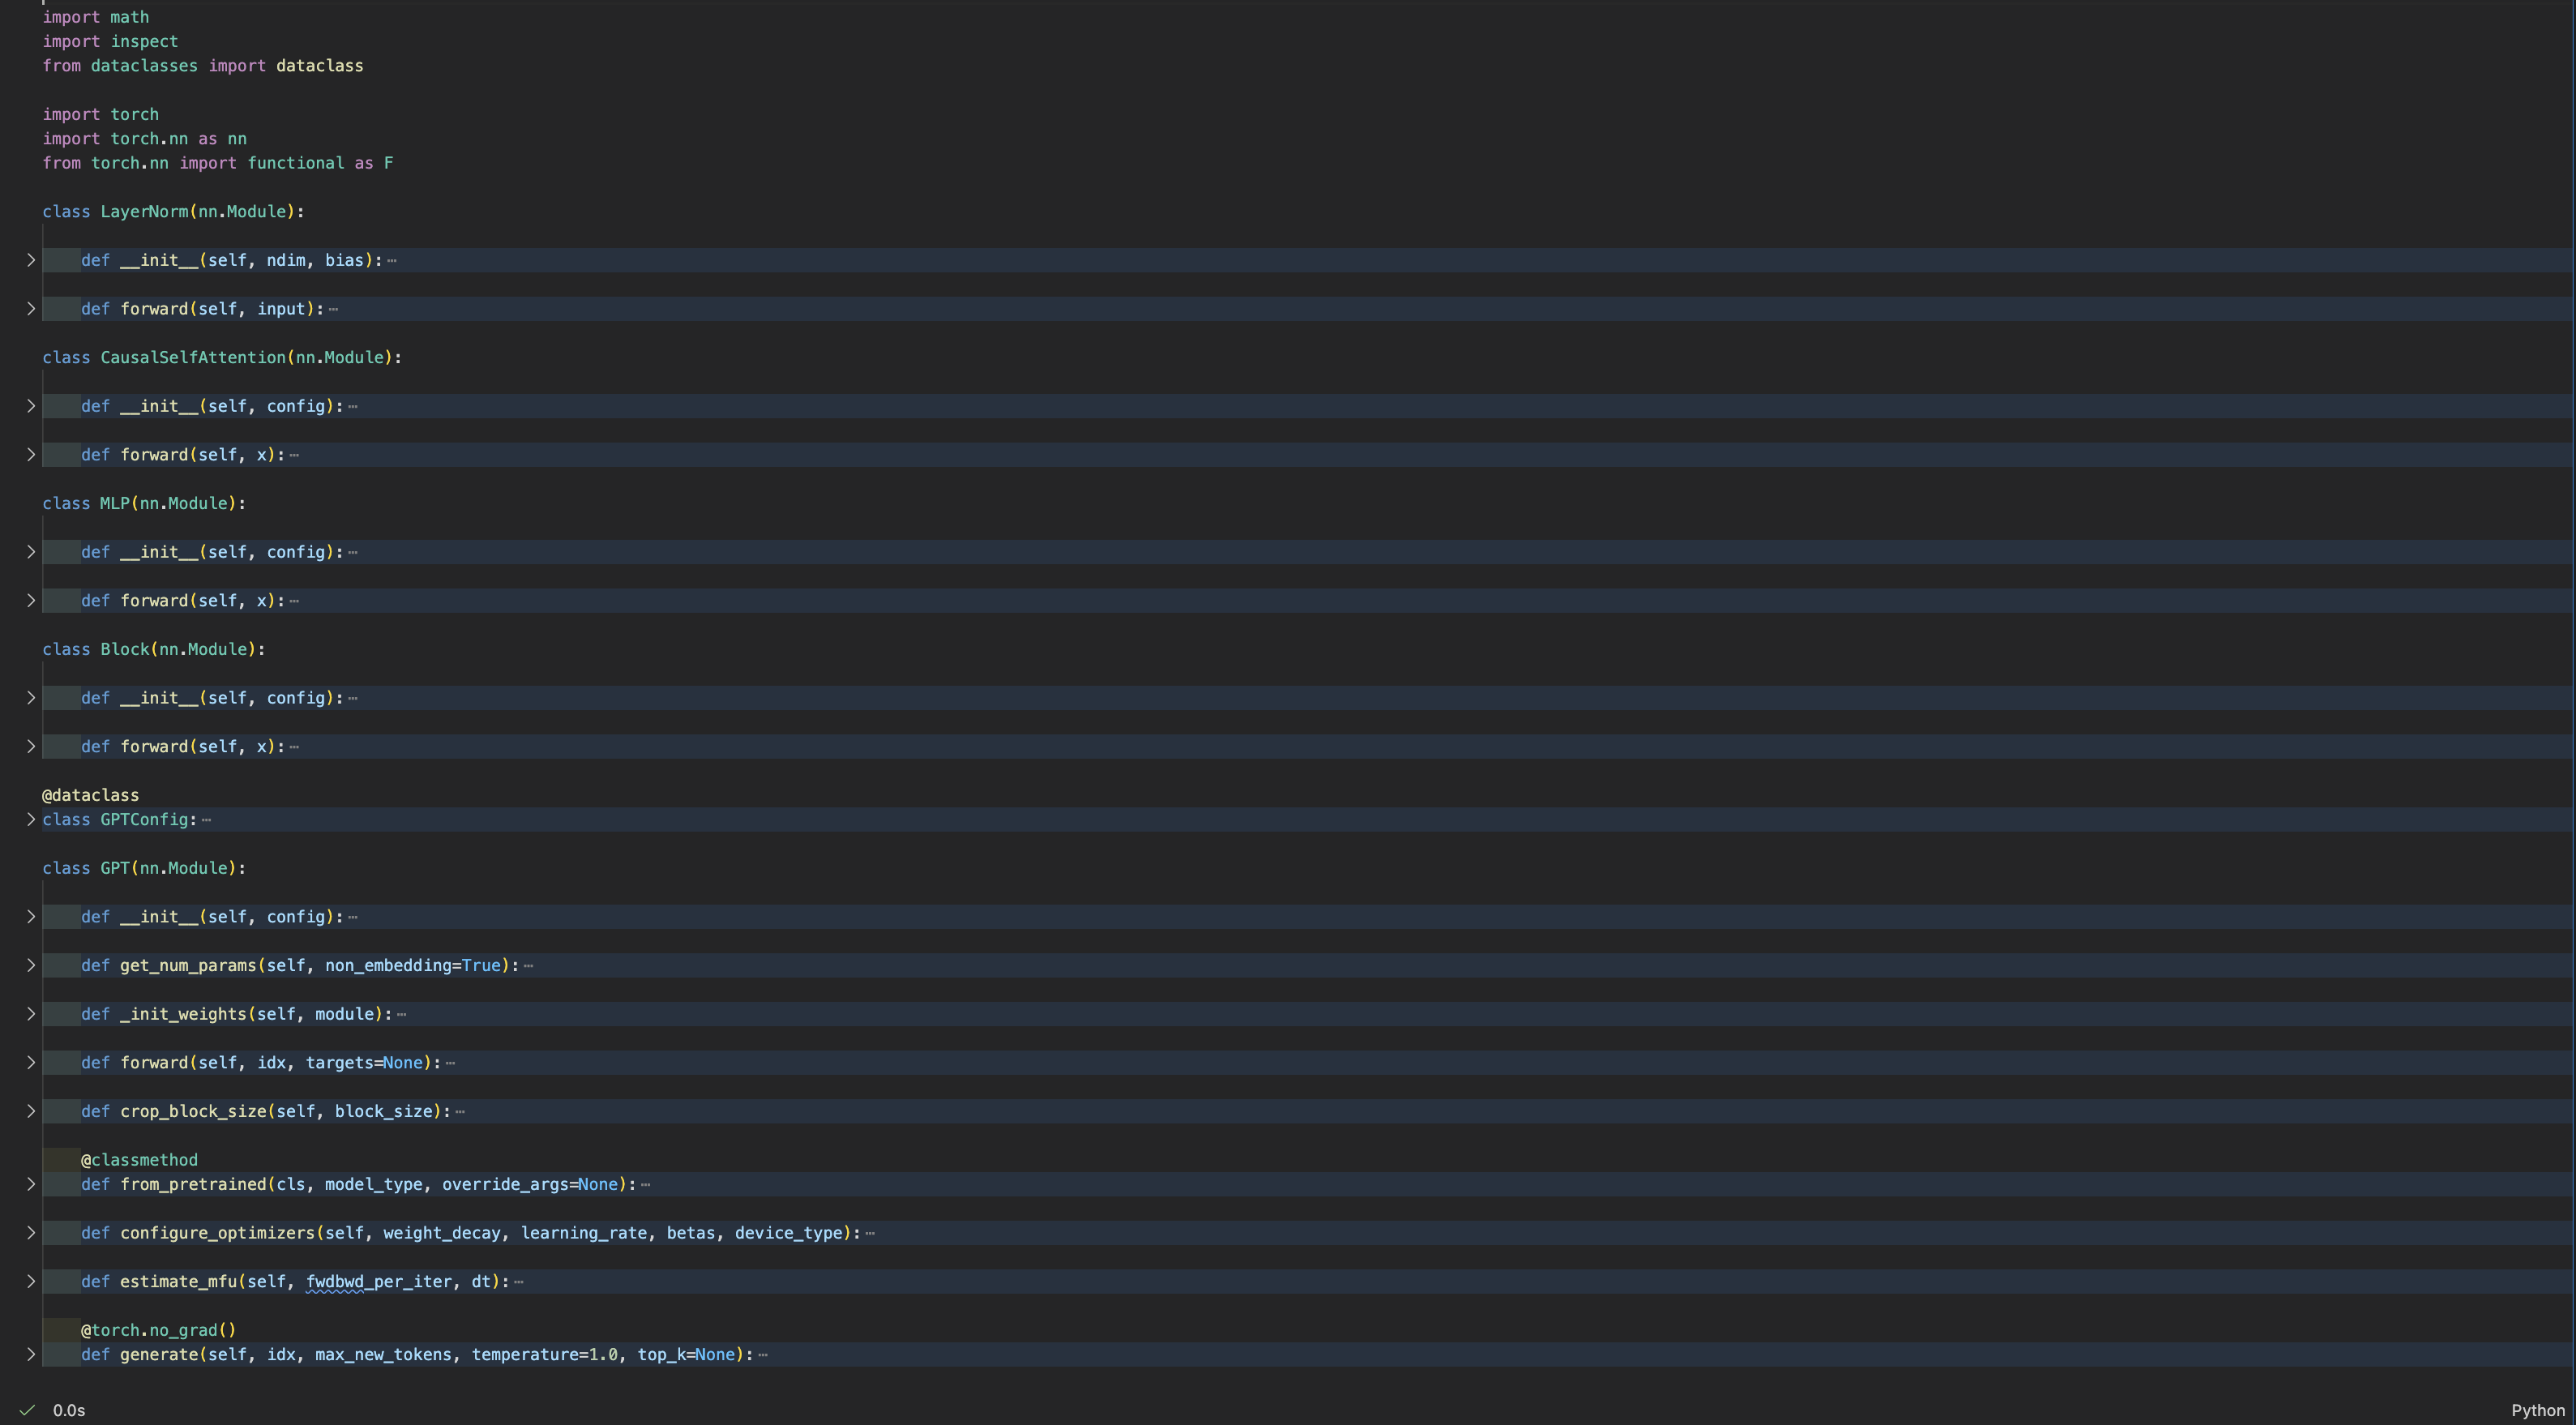

In [ ]:
# """
# Full definition of a GPT Language Model, all of it in this single file.
# References:
# 1) the official GPT-2 TensorFlow implementation released by OpenAI:
# https://github.com/openai/gpt-2/blob/master/src/model.py
# 2) huggingface/transformers PyTorch implementation:
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
# """

# import math
# import inspect
# from dataclasses import dataclass

# import torch
# import torch.nn as nn
# from torch.nn import functional as F

# class LayerNorm(nn.Module):

#     def __init__(self, ndim, bias):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(ndim))
#         self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

#     def forward(self, input):
#         return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

# class CausalSelfAttention(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.n_embd % config.n_head == 0
#         # key, query, value projections for all heads, but in a batch
#         self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
#         # output projection
#         self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
#         # regularization
#         self.attn_dropout = nn.Dropout(config.dropout)
#         self.resid_dropout = nn.Dropout(config.dropout)
#         self.n_head = config.n_head
#         self.n_embd = config.n_embd
#         self.dropout = config.dropout
#         # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
#         self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
#         if not self.flash:
#             print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
#             # causal mask to ensure that attention is only applied to the left in the input sequence
#             self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
#                                         .view(1, 1, config.block_size, config.block_size))

#     def forward(self, x):
#         B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

#         # calculate query, key, values for all heads in batch and move head forward to be the batch dim
#         q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
#         k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

#         # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
#         if self.flash:
#             # efficient attention using Flash Attention CUDA kernels
#             y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
#         else:
#             # manual implementation of attention
#             att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
#             att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
#             att = F.softmax(att, dim=-1)
#             att = self.attn_dropout(att)
#             y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
#         y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

#         # output projection
#         y = self.resid_dropout(self.c_proj(y))
#         return y

# class MLP(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#         self.gelu    = nn.GELU()
#         self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#         self.dropout = nn.Dropout(config.dropout)

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         x = self.dropout(x)
#         return x

# class Block(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
#         self.attn = CausalSelfAttention(config)
#         self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
#         self.mlp = MLP(config)

#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x))
#         x = x + self.mlp(self.ln_2(x))
#         return x

# @dataclass
# class GPTConfig:
#     block_size: int = 1024
#     vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
#     n_layer: int = 12
#     n_head: int = 12
#     n_embd: int = 768
#     dropout: float = 0.0
#     bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

# class GPT(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.vocab_size is not None
#         assert config.block_size is not None
#         self.config = config

#         self.transformer = nn.ModuleDict(dict(
#             wte = nn.Embedding(config.vocab_size, config.n_embd),
#             wpe = nn.Embedding(config.block_size, config.n_embd),
#             drop = nn.Dropout(config.dropout),
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = LayerNorm(config.n_embd, bias=config.bias),
#         ))
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
#         # with weight tying when using torch.compile() some warnings get generated:
#         # "UserWarning: functional_call was passed multiple values for tied weights.
#         # This behavior is deprecated and will be an error in future versions"
#         # not 100% sure what this is, so far seems to be harmless. TODO investigate
#         self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

#         # init all weights
#         self.apply(self._init_weights)
#         # apply special scaled init to the residual projections, per GPT-2 paper
#         for pn, p in self.named_parameters():
#             if pn.endswith('c_proj.weight'):
#                 torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

#         # report number of parameters
#         print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

#     def get_num_params(self, non_embedding=True):
#         """
#         Return the number of parameters in the model.
#         For non-embedding count (default), the position embeddings get subtracted.
#         The token embeddings would too, except due to the parameter sharing these
#         params are actually used as weights in the final layer, so we include them.
#         """
#         n_params = sum(p.numel() for p in self.parameters())
#         if non_embedding:
#             n_params -= self.transformer.wpe.weight.numel()
#         return n_params

#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
#             if module.bias is not None:
#                 torch.nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

#     def forward(self, idx, targets=None): # idx = token indices; 'idx' is of shape (B, T) Batch and Time
#         device = idx.device
#         b, t = idx.size()
#         assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
#         pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

#         # forward the GPT model itself
#         tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
#         pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
#         x = self.transformer.drop(tok_emb + pos_emb)
#         for block in self.transformer.h:
#             x = block(x)
#         x = self.transformer.ln_f(x)

#         if targets is not None:
#             # if we are given some desired targets also calculate the loss
#             logits = self.lm_head(x)
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
#         else:
#             # inference-time mini-optimization: only forward the lm_head on the very last position
#             logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
#             loss = None

#         return logits, loss

#     def crop_block_size(self, block_size):
#         # model surgery to decrease the block size if necessary
#         # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
#         # but want to use a smaller block size for some smaller, simpler model
#         assert block_size <= self.config.block_size
#         self.config.block_size = block_size
#         self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
#         for block in self.transformer.h:
#             if hasattr(block.attn, 'bias'):
#                 block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

#     @classmethod
#     # a constructor [ a '@classmethod' in python] which returns the GPT object, once the 'model_type' is given.
#     # in our case it's GPT-2 124M
#     def from_pretrained(cls, model_type, override_args=None):
#         assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
#         override_args = override_args or {} # default to empty dict
#         # only dropout can be overridden see more notes below
#         assert all(k == 'dropout' for k in override_args)
#         from transformers import GPT2LMHeadModel
#         print("loading weights from pretrained gpt: %s" % model_type)

#         # n_layer, n_head and n_embd are determined from model_type
#         config_args = {
#             'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
#             'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
#             'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
#             'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
#         }[model_type]
#         print("forcing vocab_size=50257, block_size=1024, bias=True")
#         config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
#         config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
#         config_args['bias'] = True # always True for GPT model checkpoints
#         # we can override the dropout rate, if desired
#         if 'dropout' in override_args:
#             print(f"overriding dropout rate to {override_args['dropout']}")
#             config_args['dropout'] = override_args['dropout']
#         # create a from-scratch initialized minGPT model
#         config = GPTConfig(**config_args)
#         model = GPT(config)
#         sd = model.state_dict()
#         sd_keys = sd.keys()
#         sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

#         # init a huggingface/transformers model
#         model_hf = GPT2LMHeadModel.from_pretrained(model_type)
#         sd_hf = model_hf.state_dict()

#         # copy while ensuring all of the parameters are aligned and match in names and shapes
#         sd_keys_hf = sd_hf.keys()
#         sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
#         sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
#         transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
#         # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
#         # this means that we have to transpose these weights when we import them
#         assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
#         for k in sd_keys_hf:
#             if any(k.endswith(w) for w in transposed):
#                 # special treatment for the Conv1D weights we need to transpose
#                 assert sd_hf[k].shape[::-1] == sd[k].shape
#                 with torch.no_grad():
#                     sd[k].copy_(sd_hf[k].t())
#             else:
#                 # vanilla copy over the other parameters
#                 assert sd_hf[k].shape == sd[k].shape
#                 with torch.no_grad():
#                     sd[k].copy_(sd_hf[k])

#         return model

#     def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
#         # start with all of the candidate parameters
#         param_dict = {pn: p for pn, p in self.named_parameters()}
#         # filter out those that do not require grad
#         param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
#         # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
#         # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
#         decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
#         nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
#         optim_groups = [
#             {'params': decay_params, 'weight_decay': weight_decay},
#             {'params': nodecay_params, 'weight_decay': 0.0}
#         ]
#         num_decay_params = sum(p.numel() for p in decay_params)
#         num_nodecay_params = sum(p.numel() for p in nodecay_params)
#         print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
#         print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
#         # Create AdamW optimizer and use the fused version if it is available
#         fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
#         use_fused = fused_available and device_type == 'cuda'
#         extra_args = dict(fused=True) if use_fused else dict()
#         optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
#         print(f"using fused AdamW: {use_fused}")

#         return optimizer

#     def estimate_mfu(self, fwdbwd_per_iter, dt):
#         """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
#         # first estimate the number of flops we do per iteration.
#         # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
#         N = self.get_num_params()
#         cfg = self.config
#         L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
#         flops_per_token = 6*N + 12*L*H*Q*T
#         flops_per_fwdbwd = flops_per_token * T
#         flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
#         # express our flops throughput as ratio of A100 bfloat16 peak flops
#         flops_achieved = flops_per_iter * (1.0/dt) # per second
#         flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
#         mfu = flops_achieved / flops_promised
#         return mfu

#     @torch.no_grad()
#     def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
#         """
#         Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
#         the sequence max_new_tokens times, feeding the predictions back into the model each time.
#         Most likely you'll want to make sure to be in model.eval() mode of operation for this.
#         """
#         for _ in range(max_new_tokens):
#             # if the sequence context is growing too long we must crop it at block_size
#             idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
#             # forward the model to get the logits for the index in the sequence
#             logits, _ = self(idx_cond)
#             # pluck the logits at the final step and scale by desired temperature
#             logits = logits[:, -1, :] / temperature
#             # optionally crop the logits to only the top k options
#             if top_k is not None:
#                 v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#                 logits[logits < v[:, [-1]]] = -float('Inf')
#             # apply softmax to convert logits to (normalized) probabilities
#             probs = F.softmax(logits, dim=-1)
#             # sample from the distribution
#             idx_next = torch.multinomial(probs, num_samples=1)
#             # append sampled index to the running sequence and continue
#             idx = torch.cat((idx, idx_next), dim=1)

#         return idx


In [ ]:
# # skeleton of the GPT2
# class GPT(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.vocab_size is not None
#         assert config.block_size is not None
#         self.config = config

#         self.transformer = nn.ModuleDict(dict(
#             wte = nn.Embedding(config.vocab_size, config.n_embd),
#             wpe = nn.Embedding(config.block_size, config.n_embd),
#             # drop = nn.Dropout(config.dropout),
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = nn.LayerNorm(config.n_embd), # , bias=config.bias
#         ))
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

In [ ]:
# model = GPT.from_pretrained("gpt2")
# print('🎉 Valla, the model did not crash! 🥳')

AttributeError: type object 'GPT' has no attribute 'from_pretrained'

#### my codes

    Now can load the Weights, Biases, and every single else, into our 'nn.Module'.
    Before we do this, in order to get additional confidence, so let's generate from this model!

In [ ]:
# # Verifying to see if CUDA is set!

# import torch
# print(torch.cuda.is_available())   # False
# print(torch.version.cuda) # If CUDA is None → CPU-only build.

False
None


In [ ]:
# # we can use the following if we are not sure if we have the CUDA installed or not
# # if not installed then move to CPU

# device = (
#     "cuda" if torch.cuda.is_available()
#     else "mps" if torch.backends.mps.is_available()
#     else "cpu"
# )
# model.to(device)

#### getting back to the stream ...

In [ ]:
# num_return_sequences = 5
# max_length = 30

# model = GPT. from_pretrained('gpt2') # initializing our model 
# model. eval() # evaluation mode, putting the model into 'eval' when we are not going to training it, and only using it

# # model.to('cuda') # moving the entire model to CUDA, shipping off all of the tensors to GPU. It's better to SSH with GPUs inside! A whole separate computer...

# # I do not have CUDA installed then let's stay with the cpu
# device = torch.device("cpu");
# model.to(device);

NameError: name 'GPT' is not defined

    creating the prefix tokens ...

In [ ]:
# import tiktoken
# enc = tiktoken.get_encoding('gpt2')
# tokens = enc.encode("Here we are on December 31st 2025, and it's 23:59, and there is nothing left")
# tokens = torch.tensor(tokens, dtype=torch.long) # creating a torch tensor out of the tokens. 8 tokens
# tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8) replicating the 8 tokens in 5 times to get 5 rows of 8 tokens
# # x = tokens.to('cuda')
# device = torch.device("cpu")
# x = tokens.to(device) # out initial input x, lives on the CPU

# # remember that the 'x' is the 'idx' in the 'forward' function inside 'GPT' where we get our 'logits' from which we will know what is going to come next
# # as the 9th token, in every one of the 5 rows

    At the every single iteration of the following 'while' loop we are going to be adding a column of new indices into each of the rows
    And so the new indices, where we appending them to the sequence, as we are sampling
    So, with each loop iteration, we get one more column into 'x'

In [ ]:
# # generate! right now x is (B, T) where B = 5, T = 8
# # set the seed to 42
# torch.manual_seed (42)
# # torch.cuda.manual_seed (42)

# while x.size(1) < max_length:
#     # forward the model to get the logits
    
#     # all of the following operations happens under the context manager of 'torch.no_grad()' 
#     # which tell the pytorch that we are going to call '.backward()' on any of the lines below
#     with torch.no_grad(): 
#         logits, _ = model (x) # (B,T, vocab_size)
#         # take the logits at the last position
#         logits = logits[:, -1, :] # (B, vocab_size)
#         # get the probabilities
#         probs = F.softmax(logits,dim=-1)
#         # do top-k sampling of 50 (huggingface pipeline default)
#         # # topk_probs here becomes (5, 50), topk_indices is (5, 50)
#         topk_probs, topk_indices = torch. topk(probs, 50, dim=-1)
#         # select a token from the top-k probabilities
#         ix = torch. multinomial(topk_probs, 1) # (B, 1)
#         # gather the corresponding indices
#         xcol = torch. gather(topk_indices, -1,ix) # (B, 1)
#         # append to the sequence
#         x = torch. cat((x, xcol), dim=1)
    
#     # print the generated text
#     for i in range(num_return_sequences) :
#         tokens =x[i,:max_length].tolist() # getting all the tokens that were sampled
#         decoded = enc. decode(tokens)
#         print (">", decoded)

> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left.
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left.
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to do
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left. It
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to say
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to do
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left. On
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left to do in
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left. It j

#### my code on to see how much work I draw from the CPU while model running

In [ ]:
# import time
# import psutil
# import torch
# import os

# process = psutil.Process(os.getpid())

# # warm-up (important)
# _ = model.generate(torch.randint(0, 50257, (1, 5)), max_length=max_length)

# cpu_before = process.cpu_times()
# t0 = time.time()

# with torch.no_grad():
#     _ = model.generate(
#         torch.randint(0, 50257, (1, 5)),
#         max_length=max_length,
#         num_return_sequences=num_return_sequences,
#         do_sample=True
#     )

# t1 = time.time()
# cpu_after = process.cpu_times()

# cpu_time_used = (
#     (cpu_after.user - cpu_before.user) +
#     (cpu_after.system - cpu_before.system)
# )

# print(f"Wall time: {t1 - t0:.3f} s")
# print(f"CPU time used: {cpu_time_used:.3f} s")
# print(f"CPU utilization: {100 * cpu_time_used / (t1 - t0):.1f}%")

TypeError: GPT.generate() got an unexpected keyword argument 'max_length'

## **00:41:47 - 00:00:00**
- initializing our model from scratch, from random numbers 
- train the model, giving us the sequences as good as, or better, than the generated output from the previous section, in quality.

    let's perform a random model initialization!
        - toggle off the 'model = GPT. from_pretrained(gpt2')'
        - and put 'model = GPT(GPTConfig())' instead
        - and receive total garbage 🤗 since our model is a random model. Random model would produce random output

In [ ]:
# # detecting the device to run on that has the highest compute capability

# device ="cpu" # default

# if torch.cuda.is_available():
#     device ="cpu"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device ="mps" # potentially faster than CPU

# print(f" Using Device: {device}")

# num_return_sequences = 5
# max_length = 30

# #model = GPT. from_pretrained('gpt2')
# model = GPT(GPTConfig())
# model. eval()

# device = torch.device(device);
# model.to(device);

# import tiktoken
# enc = tiktoken.get_encoding('gpt2')
# tokens = enc.encode("Here we are on December 31st 2025, and it's 23:59, and there is nothing left")
# tokens = torch.tensor(tokens, dtype=torch.long)
# tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
# # x = tokens.to('cuda')
# device = torch.device(device)
# x = tokens.to(device)

# torch.manual_seed (42)

# while x.size(1) < max_length:

#     with torch.no_grad(): 
#         logits, _ = model (x)
#         logits = logits[:, -1, :]
#         probs = F.softmax(logits,dim=-1)
#         topk_probs, topk_indices = torch. topk(probs, 50, dim=-1)
#         ix = torch. multinomial(topk_probs, 1)
#         xcol = torch. gather(topk_indices, -1,ix)
#         x = torch. cat((x, xcol), dim=1)
        
#     for i in range(num_return_sequences) :
#         tokens =x[i,:max_length].tolist()
#         decoded = enc. decode(tokens)
#         print (">", decoded)

 Using Device: mps
number of parameters: 123.69M
> Here we are on December 31st 2025, and it's 23:59, and there is nothing leftjas
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left primates
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left internet
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left professionals
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left valleys
> Here we are on December 31st 2025, and it's 23:59, and there is nothing leftjas Upgrade
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left primates daddy
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left internet internet
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left professionals reporters
> Here we are on December 31st 2025, and it's 23:59, and there is nothing left valleys backbone
> Here we are on December 31st 20

    Karpathy:
        - "If you don't have CUDA you may follow along to some extent, and there is a method that you can "autodetect" the device that is available to you, in PyTorch."
        - we need to install CUDA since we will be using multiple GPUs and do the serious training runs.
        - we may put the following code to the beginning of the code block above

In [ ]:
# # detecting the device to run on that has the highest compute capability

# device ="cpu" # default

# if torch.cuda.is_available():
#     device ="cpu"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device ="mps" # potentially faster than CPU

# print(f" Using Device: {device}")

 Using Device: mps


    Now let's dive int TRAINING the MODEL

    1. we need some dataset, let's use the tiny shakespeare dataset

In [ ]:
# # tiny shakespeare dataset
# #!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# with open('input.txt', 'r') as f:
#     text = f. read()

# data = text[:1000] # first 1,000 characters

# print (data [:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [ ]:
# # performing Word Count
# ! wc input.txt;
# # 40_000 lines
# # 202_651 words
# # 1_115_394 bytes [characters]

   40000  202651 1115394 input.txt


Python(79763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


    Tokenizing the dataset

In [ ]:
# import tiktoken
# enc = tiktoken.get_encoding("gpt2")
# tokens = enc.encode(data)
# print(tokens[:20])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248]


    Now, let's process these token sequences and feed them into a transformer
    And, in particular we want to rearrange the tokens into the 'idx' variable in our model, that we will be feeding into the transformer

    So, we don't want a one-dimensional sequence
    We need a (B,T) shape output, we need the a batch 'B' where each sequence is 'T' tokens [T = max sequence length],
    so in each 'B' we will have 'T' long sequence of tokens, and 'B' independent examples of sequences 
    So, how to create a BxT tensor, feed into the forward, out of the one dimensional sequence above? Let's go!
    [5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248]

In [ ]:
# import torch
# buf = torch.tensor(tokens[:24]) # creating tensor object out of the list of integers 'tokens[:24]'
# x = buf.view(4,6)
# print(x)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])


    Now, in terms of the label that we are going to need to calculate the loss function, how do we get that?
        - the label for instance for the '25' is the '198'
        - however, for the '13' no labels exist, since we didn't load it.
    
    Now, Karpathy is going to show his favorite way in
        - getting the batches
        - not only to have the input to the transformer which we called 'x' 
        - but also to create the labels tensor which is of the exact same size as 'x' but contains the targets at every single position

In [ ]:
# import torch
# buf = torch.tensor(tokens[:24 + 1]) # '+ 1' as we need to fetch the ground truth for the very last token '13' [B * T + 1]
# x = buf[:-1].view(4,6) # [:-1] up to last token
# y = buf[1:].view(4, 6)
# print(x) # input to the transformer
# print(y) # labels

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


    Now, the token '13' has its own label which is '198'

    We did this to create a "dataloader" object! Which loads all the tokens, feed them to the transformer, and calculate the loss.
    Following is the full code ...

In [ ]:
# @dataclass
# class GPTConfig:
#     block_size: int = 1024
#     vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
#     n_layer: int = 12
#     n_head: int = 12
#     n_embd: int = 768
#     dropout: float = 0.0
#     bias: bool = True # 

In [ ]:
# import torch
# import tiktoken
# # --------------------
# # device autodetection
# # --------------------
# device ="cpu"
# if torch.cuda.is_available():
#     device ="cuda"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device ="mps"
# print(f" Using Device: {device}")
# # --------------------
# # load + tokenize data
# # --------------------
# enc = tiktoken.get_encoding("gpt2")
# with open('input.txt', 'r') as f:
#     text = f. read()
# text = text[:1000]
# tokens = enc.encode(text)
# B, T = 4, 32
# buf = torch.tensor(tokens[:B*T + 1], device=device)
# x = buf[:-1].view(B, T)
# y = buf[1:].view(B, T)

# # --------------------
# # model forward pass
# # --------------------
# # logits
# num_return_sequences = 5
# max_length = 30
# model = GPT(GPTConfig()).to(device)
# model.eval()
# logits, _ = model(x)
# print(logits.shape)
# import sys; sys.exit(0)

 Using Device: mps
number of parameters: 123.69M
torch.Size([4, 1, 50304])


/Users/soheilsanati/Downloads/Canopus/.venv/lib/python3.12/site-packages/IPython/core/magics/execution.py:495: UserWarning: Error changing user exception modes.
Unrecognized mode in FormattedTB: <Sys.exit(0)>
Valid modes: ['Plain', 'Context', 'Verbose', 'Minimal']
  warn('Error changing %s exception modes.\n%s' %


In [ ]:
# print(x.device, next(model.parameters()).device)

mps:0 mps:0


Starting over ...

In [ ]:
# @dataclass
# class GPTConfig:
#     block_size: int = 256
#     vocab_size: int = 65
#     n_layer: int = 6
#     n_head: int = 6
#     n_embd: int = 384
#     bias: bool = False
#     dropout: float = 0,1

# class LayerNorm(nn.Module):

#     def __init__(self, ndim, bias):
#         super().__init__()
#         self.weight = nn.Parameter(torch.ones(ndim))
#         self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

#     def forward(self, input):
#         return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

# class Block(nn.Module):

# # initializations
#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
#         self.attn = CausalSelfAttention(config)
#         self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
#         self.mlp = MLP(config)

# # Forward pass
#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x))
#         x = x + self.mlp(self.ln_2(x))
#         return x

# class MLP(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
#         self.gelu    = nn.GELU(approximate="tanh")
#         self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
#         self.dropout = nn.Dropout(config.dropout)

#     def forward(self, x):
#         x = self.c_fc(x)
#         x = self.gelu(x)
#         x = self.c_proj(x)
#         x = self.dropout(x)
#         return x
    
# class CausalSelfAttention(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.n_embd % config.n_head == 0
#         # key, query, value projections for all heads, but in a batch
#         self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
#         # output projection
#         self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
#         # regularization
#         self.attn_dropout = nn.Dropout(config.dropout)
#         self.resid_dropout = nn.Dropout(config.dropout)
#         self.n_head = config.n_head
#         self.n_embd = config.n_embd
#         self.dropout = config.dropout
#         # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
#         self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
#         if not self.flash:
#             print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
#             # causal mask to ensure that attention is only applied to the left in the input sequence
#             self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
#                                         .view(1, 1, config.block_size, config.block_size))

#     def forward(self, x):
#         B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

#         # calculate query, key, values for all heads in batch and move head forward to be the batch dim
#         q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
#         k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
#         v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

#         # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
#         if self.flash:
#             # efficient attention using Flash Attention CUDA kernels
#             y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
#         else:
#             # manual implementation of attention
#             att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
#             att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
#             att = F.softmax(att, dim=-1)
#             att = self.attn_dropout(att)
#             y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
#         y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side [performing the concatenation operation]

#         # output projection
#         y = self.resid_dropout(self.c_proj(y))
#         return y

# # skeleton of the GPT2
# class GPT(nn.Module):

#     def __init__(self, config):
#         super().__init__()
#         assert config.vocab_size is not None
#         assert config.block_size is not None
#         self.config = config

#         self.transformer = nn.ModuleDict(dict(
#             wte = nn.Embedding(config.vocab_size, config.n_embd),
#             wpe = nn.Embedding(config.block_size, config.n_embd),
#             drop = nn.Dropout(config.dropout),
#             h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
#             ln_f = nn.LayerNorm(config.n_embd), # , bias=config.bias
#         ))
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)



In [ ]:
# import torch
# import tiktoken
# # --------------------
# # device autodetection
# # --------------------
# device ="cpu"
# if torch.cuda.is_available():
#     device ="cuda"
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device ="mps"
# print(f" Using Device: {device}")
# # --------------------
# # load + tokenize data
# # --------------------
# enc = tiktoken.get_encoding("gpt2")
# with open('input.txt', 'r') as f:
#     text = f. read()
# text = text[:1000]
# tokens = enc.encode(text)
# B, T = 4, 32
# buf = torch.tensor(tokens[:B*T + 1], device=device)
# x = buf[:-1].view(B, T)
# y = buf[1:].view(B, T)

# # --------------------
# # model forward pass
# # --------------------
# # logits
# num_return_sequences = 5
# max_length = 30
# model = GPT(GPTConfig()).to(device)
# model.eval()
# logits, _ = model(x)
# print(logits.shape)
# import sys; sys.exit(0)

 Using Device: mps


TypeError: '<' not supported between instances of 'tuple' and 'int'

# New ...